# Forest Fire Data Linear Regression Models

#### This data and lab are based on the work published in: Cortez, Paulo & Morais, A. (2007). A Data Mining Approach to Predict Forest Fires Using Meteorological Data.

## Initial Imports

In [148]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sbn
import numpy as np
from sklearn import linear_model 
from sklearn import model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## Get Data

In [149]:
fd = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

## Review Data

In [150]:
fd.shape

(517, 13)

In [151]:
fd

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [152]:
fd.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# Visualize some data

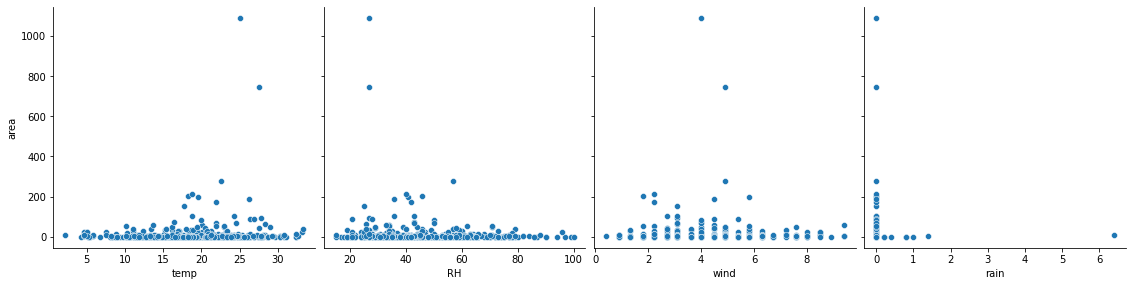

In [153]:
sbn.pairplot(fd, x_vars=['temp', 'RH','wind', 'rain'], y_vars='area', height=4, aspect=1, kind='scatter')
plt.show()

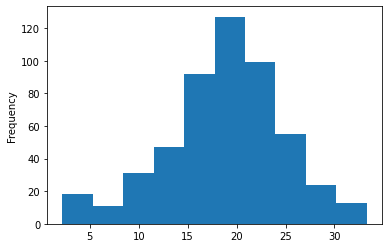

In [154]:
fd['temp'].plot.hist()

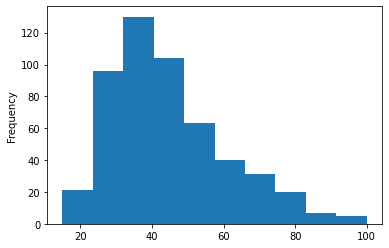

In [155]:
fd['RH'].plot.hist()

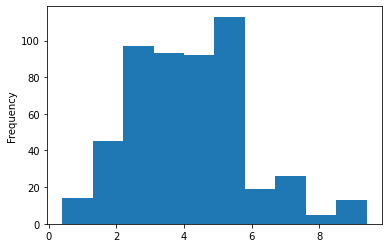

In [156]:
fd['wind'].plot.hist()

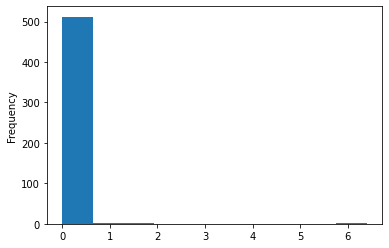

In [157]:
fd['rain'].plot.hist()

# Transform area

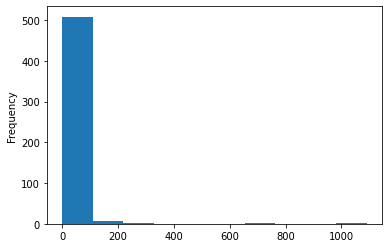

In [158]:
fd['area'].plot.hist()

### In the paper 'A Data Mining Approach to Predict Forest Fires using Meteorological Data' (Cortez and Morais, 2007), the authors state that, "To reduce skewness and improve symmetry," they applied a ln(x + 1) transform (and its inverse (exp(x) - 1) on the output), to the area attribute.  Here I'm adding the transformed_area to the data so I can perform the regressions with both areas and compare the differences.   One thing I will mention again below is that the authors did not use R2 or MSE for their metric, they used RMSE.  I assumed that if the transform on area improved RMSE, it might improve MSE as well.

### Here I apply the ln(x + 1) transform to the area and add that transformed_area as a new column to the dataset.

In [159]:
fd['transformed_area'] = fd['area'].apply(lambda x: np.log(x + 1))  # np.log is numpy's ln().

In [160]:
fd

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,transformed_area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,2.006871
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,4.012592
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,2.498152
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000


### The histogram for the new transformed_area attribute

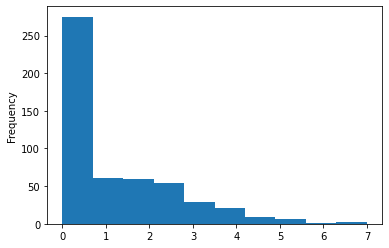

In [161]:
fd['transformed_area'].plot.hist()

## Shape columns

In [162]:
x_temp = np.c_[fd['temp']]
x_RH = np.c_[fd['RH']]
x_wind = np.c_[fd['wind']]
x_rain = np.c_[fd['rain']]
y_area = np.c_[fd['area']]
y_transformed_area = np.c_[fd['transformed_area']]

## Split 80-20

### Note: 
#### I'm creating a set of splits for each regression.  I wondered if that would make the models less-comparable, thinking they should be trained and tested on the same splits of the dataset, but the goal is to get a model that generalizes well, and the random_state=100 should ensure that the area attribute gets split the same way in each case.  

### Function do_splits just wraps train_test_split with train_size, test_size, and random_state fixed, mostly for cleanliness.

In [163]:
def do_splits(x, y):
    results = []
    results = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 100)#, random_state = 100
    return results

#### Here I'm creating one set of splits for the regressions against the transformed area and then four more using the nontransformed area.

In [164]:
t_temp_splits = do_splits(x_temp, y_transformed_area)
t_RH_splits = do_splits(x_RH, y_transformed_area)
t_wind_splits = do_splits(x_wind, y_transformed_area)
t_rain_splits = do_splits(x_rain, y_transformed_area)

temp_splits = do_splits(x_temp, y_area)
RH_splits = do_splits(x_RH, y_area)
wind_splits = do_splits(x_wind, y_area)
rain_splits = do_splits(x_rain, y_area)

## Create the linear regression models with the transformed area data.

In [165]:
temp_t_lm = linear_model.LinearRegression()
RH_t_lm = linear_model.LinearRegression()
wind_t_lm = linear_model.LinearRegression()
rain_t_lm = linear_model.LinearRegression()

## Fit the model and plot.

In [166]:
temp_t_lm.fit(t_temp_splits[0], t_temp_splits[2])
intercept = np.exp(temp_t_lm.intercept_)-1
slope = np.exp(temp_t_lm.coef_)-1
print("Intercept :", intercept)
print('Slope :', slope)

Intercept : [1.32141828]
Slope : [[0.01514093]]


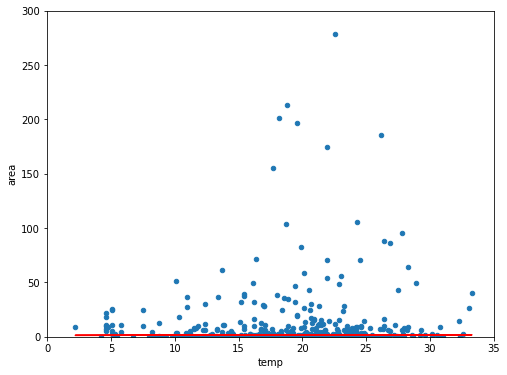

In [167]:
fd.plot(kind='scatter', x='temp', y='area', figsize=(8, 6))
plt.axis([0, 35, 0, 300])
plt.plot(x_temp, intercept + slope*x_temp, 'r')
plt.show()

## Same data and line, different scale

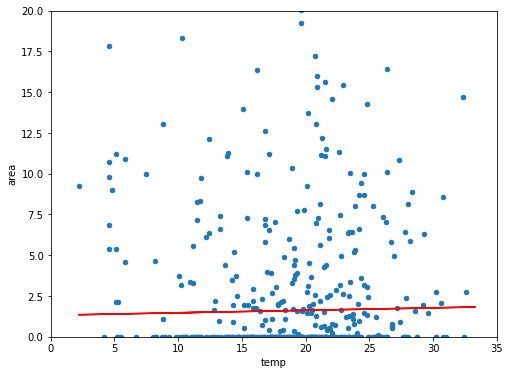

In [168]:
fd.plot(kind='scatter', x='temp', y='area', figsize=(8, 6))
plt.axis([0, 35, 0, 20])
plt.plot(x_temp, intercept + slope*x_temp, 'r')
plt.show()

## Make predictions, remembering to use the inverse transform on output.

In [169]:
# predict on the training set
y_t_temp_train_pred = np.exp(temp_t_lm.predict(t_temp_splits[0])) - 1
# predict on the test set
y_t_temp_test_pred = np.exp(temp_t_lm.predict(t_temp_splits[1])) - 1


r2_score_temp = r2_score(t_temp_splits[3], y_t_temp_test_pred)
print('Temp-Area R2 score(with transform):', r2_score_temp)
mse_temp = mean_squared_error(t_temp_splits[3], y_t_temp_test_pred)
print('Temp-Area mean squared error(with transform):', mse_temp)

Temp-Area R2 score(with transform): -0.6577821677341165
Temp-Area mean squared error(with transform): 2.950415773303055


## Here I'll wrap the fitting, predicting, and scoring in a function called 'train_predict_eval()' to make the other regressions cleaner

In [170]:
def train_prerdict_eval(lm, split_array, transformed="True"):
    # results array
    results = []
    
    x_trn = split_array[0]
    x_tst = split_array[1]
    y_trn = split_array[2]
    y_tst = split_array[3]
    
    # Fit the model
    lm.fit(x_trn, y_trn)
    
    # if this is being used with transformed area, these results need the inverse function applied.
    if(transformed):
        intercept = np.exp(lm.intercept_)-1
        slope = np.exp(lm.coef_)-1
    else: # But do not do that inverse prrocessing for the untransformed area attribute (!)
        intercept = lm.intercept_
        slope = lm.coef_
    
    print("Intercept :",intercept)
    print('Slope :', slope)
    
    if(transformed):
        # predict on the training set
        y_trn_pred = np.exp(lm.predict(x_trn)) - 1
        # predict on the test set
        y_tst_pred = np.exp(lm.predict(x_tst)) - 1
    else:
        # predict on the training set
        y_trn_pred = lm.predict(x_trn)
        # predict on the test set
        y_tst_pred = lm.predict(x_tst)

    r2score = r2_score(y_tst, y_tst_pred)
    print('Temp-Area R2 score(with transform):', r2score)
    mse = mean_squared_error(y_tst, y_tst_pred)
    print('Temp-Area mean squared error(with transform):', mse)
    
    results.append(intercept)
    results.append(slope)
    results.append(r2score)
    results.append(mse)
    
    return results

### And verify that the result is the same.

In [171]:
t_temp_results = train_prerdict_eval(temp_t_lm, t_temp_splits)

Intercept : [1.32141828]
Slope : [[0.01514093]]
Temp-Area R2 score(with transform): -0.6577821677341165
Temp-Area mean squared error(with transform): 2.950415773303055


## RH, wind, and rain regressions 

# RH

In [172]:
t_RH_results = train_prerdict_eval(RH_t_lm, t_RH_splits)

Intercept : [2.70056212]
Slope : [[-0.00418151]]
Temp-Area R2 score(with transform): -0.5676683945362875
Temp-Area mean squared error(with transform): 2.79003698349008


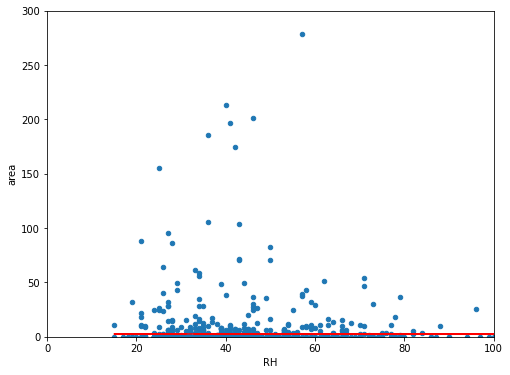

In [173]:
fd.plot(kind='scatter', x='RH', y='area', figsize=(8, 6))
plt.axis([0, 100, 0, 300])
plt.plot(x_RH, t_RH_results[0] + t_RH_results[1]*x_temp, 'r')
plt.show()

# wind

In [174]:
t_wind_results = train_prerdict_eval(wind_t_lm, t_wind_splits)

Intercept : [1.49556922]
Slope : [[0.05331657]]
Temp-Area R2 score(with transform): -0.59068721885396
Temp-Area mean squared error(with transform): 2.831004430041022


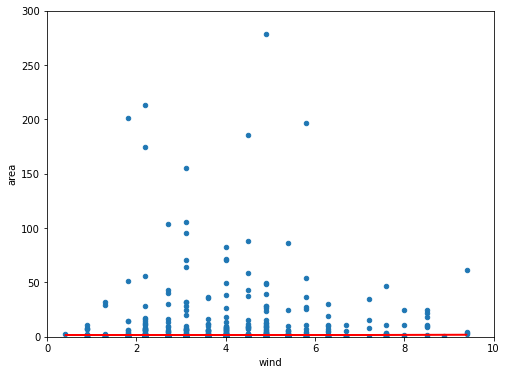

In [175]:
fd.plot(kind='scatter', x='wind', y='area', figsize=(8, 6))
plt.axis([0, 10, 0, 300])
plt.plot(x_wind, t_wind_results[0] + t_wind_results[1]*x_wind, 'r')
plt.show()

# rain

In [176]:
t_rain_results = train_prerdict_eval(rain_t_lm, rain_splits)

Intercept : [956656.05542798]
Slope : [[-0.80384302]]
Temp-Area R2 score(with transform): -1070683576.8861171
Temp-Area mean squared error(with transform): 904550904445.1776


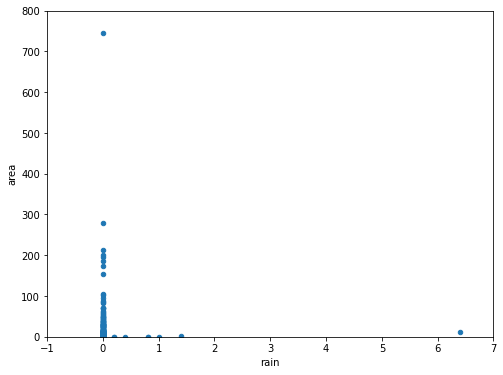

In [177]:
fd.plot(kind='scatter', x='rain', y='area', figsize=(8, 6))
plt.axis([-1, 7, 0, 800])
plt.plot(x_rain, t_rain_results[0] + t_rain_results[1]*x_rain, 'r')
plt.show()

## Now I'll create the same four models but train them on the non-transformed area data.

In [178]:
temp_lm = linear_model.LinearRegression()
RH_lm = linear_model.LinearRegression()
wind_lm = linear_model.LinearRegression()
rain_lm = linear_model.LinearRegression()

# temp

Intercept : [-12.01798625]
Slope : [[1.36887159]]
Temp-Area R2 score(with transform): -0.11059902589371906
Temp-Area mean squared error(with transform): 938.272869872064


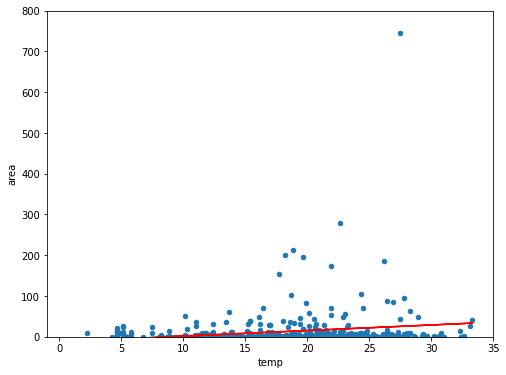

In [179]:
temp_results = train_prerdict_eval(temp_lm, temp_splits, False)

fd.plot(kind='scatter', x='temp', y='area', figsize=(8, 6))
plt.axis([-1, 35, 0, 800])
plt.plot(x_temp, temp_results[0] + temp_results[1]*x_temp, 'r')
plt.show()

# RH

Intercept : [29.37563009]
Slope : [[-0.35699106]]
Temp-Area R2 score(with transform): -0.04845187467769896
Temp-Area mean squared error(with transform): 885.7687846295037


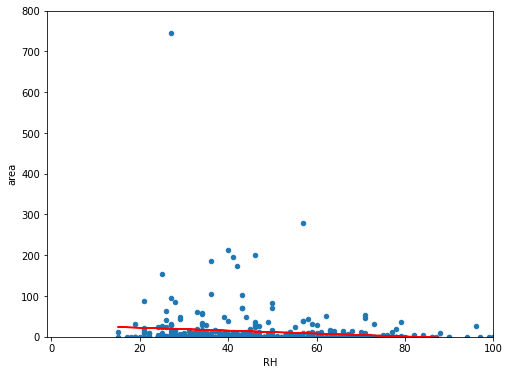

In [180]:
RH_results = train_prerdict_eval(RH_lm, RH_splits, False)
fd.plot(kind='scatter', x='RH', y='area', figsize=(8, 6))
plt.axis([-1, 100, 0, 800])
plt.plot(x_RH, RH_results[0] + RH_results[1]*x_RH, 'r')
plt.show()

# wind

Intercept : [11.94571583]
Slope : [[0.44053305]]
Temp-Area R2 score(with transform): -0.021974822191322962
Temp-Area mean squared error(with transform): 863.4000453789413


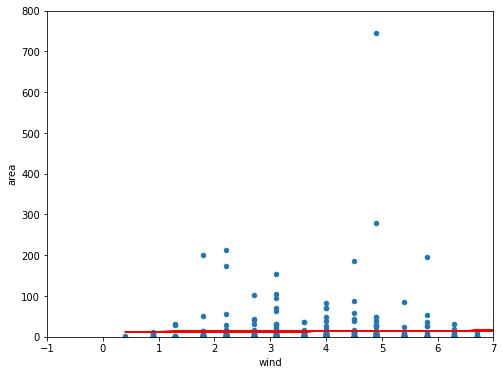

In [181]:
wind_results = train_prerdict_eval(wind_lm, wind_splits, False)
fd.plot(kind='scatter', x='wind', y='area', figsize=(8, 6))
plt.axis([-1, 7, 0, 800])
plt.plot(x_wind, wind_results[0] + wind_results[1]*x_wind, 'r')
plt.show()

# rain

Intercept : [13.77120025]
Slope : [[-1.62884002]]
Temp-Area R2 score(with transform): -0.02289617576001013
Temp-Area mean squared error(with transform): 864.1784370728861


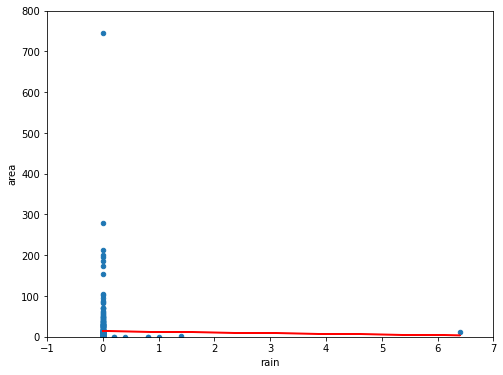

In [182]:
rain_results = train_prerdict_eval(rain_lm, rain_splits, False)
fd.plot(kind='scatter', x='rain', y='area', figsize=(8, 6))
plt.axis([-1, 7, 0, 800])
plt.plot(x_rain, rain_results[0] + rain_results[1]*x_rain, 'r')
plt.show()

# Now I'll create a dataFrame to display the results:

### Here, creating 4 series (using dicts) that will be combined into a dataframe for displaying the data.

In [183]:
r2_t_series = pd.Series({'temp' : t_temp_results[2], 'RH' : t_RH_results[2], 'wind' : t_wind_results[2], 'rain' : t_rain_results[2]})
mse_t_series = pd.Series({'temp' : t_temp_results[3], 'RH' : t_RH_results[3], 'wind' : t_wind_results[3], 'rain' : t_rain_results[3]})
r2_series = pd.Series({'temp' : temp_results[2], 'RH' : RH_results[2], 'wind' : wind_results[2], 'rain' : rain_results[2]})
mse_series = pd.Series({'temp' : temp_results[3], 'RH' : RH_results[3], 'wind' : wind_results[3], 'rain' : rain_results[3]})

### Create dictionary to build dataframe from

In [184]:
result_data = { "R2" : r2_series, "R2_trsfrmd" : r2_t_series, "MSE" : mse_series, "MSE_trsfrmd" : mse_t_series }

### Build the dataframe

In [185]:
results = pd.DataFrame(result_data)

## This table contains the results of the lab
### the scores from the transformed_area regressions have _trsfrmd appended to their name

In [186]:
results

,R2,R2_trsfrmd,MSE,MSE_trsfrmd
temp,-0.110599,-6.577822e-01,938.272870,2.950416e+00
RH,-0.048452,-5.676684e-01,885.768785,2.790037e+00
wind,-0.021975,-5.906872e-01,863.400045,2.831004e+00
rain,-0.022896,-1.070684e+09,864.178437,9.045509e+11


## Reflections/Analysis

#### I first wanted to address the terrible scores for rain -- I believe this shows a lack of correlation.  The rain data simply is not going  to be useful to predict forest fires, at least not on its own: the paper authors indicated that their best results were achieved by using  all four weather attributes together (using an SVM).

#### Other than the rain, this table shows that the area transform seriously reduces MSE but seems to reduce R2 as well, and we want high R2.
#### The study authors did not use R2 as a metric, focusing on RMSE.  It was a jump to assume that the transform would improve MSE as well, but it appears to have proven true.  As for R2, other data prep techniques would probably have to be used to increase it.
#### One way to get better scores would be to use cross-validation to find the score.  I did not use it becuase I had to decide what to submit out of what I experimented with and I determined it would be best to submit something I was least-uncertain about, that kept unnecessary new function use to a minimum.*

#### *cross_validation and pipelines were the two features I experimented with and decided not to use here, though I expect to use them on every subsequent lab.